In [41]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
import random
from scipy import stats
import scipy.stats as st
import matplotlib.pyplot as plt
import csv

### Data Loading/Cleaning

In [42]:
data = pd.read_csv('phishing_dataset/phishing.csv')
data.head()

Index  UsingIP  LongURL  ShortURL  Symbol@  Redirecting//  PrefixSuffix-  \
0      0        1        1         1        1              1             -1   
1      1        1        0         1        1              1             -1   
2      2        1        0         1        1              1             -1   
3      3        1        0        -1        1              1             -1   
4      4       -1        0        -1        1             -1             -1   

   SubDomains  HTTPS  DomainRegLen  ...  UsingPopupWindow  IframeRedirection  \
0           0      1            -1  ...                 1                  1   
1          -1     -1            -1  ...                 1                  1   
2          -1     -1             1  ...                 1                  1   
3           1      1            -1  ...                -1                  1   
4           1      1            -1  ...                 1                  1   

   AgeofDomain  DNSRecording  WebsiteTraffic  PageRank  GoogleIndex  \
0           -1            -1               0        -1            1   
1            1            -1               1        -1            1   
2           -1            -1               1        -1            1   
3           -1            -1               0        -1            1   
4            1             1               1        -1            1   

   LinksPointingToPage  StatsReport  class  
0                    1            1     -1  
1                    0           -1     -1  
2                   -1            1     -1  
3                    1            1      1  
4                   -1           -1      1  

[5 rows x 32 columns]

In [43]:
# dropping columns to make this datset more concise
cols_to_drop = [
    'LongURL',
    'SubDomains',
    'HTTPS',
    'AnchorURL'
]

data = data.drop(columns=cols_to_drop)
data = data.replace(-1, 0)
data = data.sample(frac=1.0)
data.head()

Index  UsingIP  ShortURL  Symbol@  Redirecting//  PrefixSuffix-  \
4226   4226        1         1        1              0              1   
6306   6306        0         0        0              0              1   
8336   8336        1         1        1              1              0   
8447   8447        1         1        0              1              0   
8181   8181        1         1        1              1              0   

      DomainRegLen  Favicon  NonStdPort  HTTPSDomainURL  ...  \
4226             1        0           0               0  ...   
6306             0        1           1               0  ...   
8336             0        1           1               1  ...   
8447             0        0           0               1  ...   
8181             1        1           1               1  ...   

      UsingPopupWindow  IframeRedirection  AgeofDomain  DNSRecording  \
4226                 0                  1            0             1   
6306                 1                  1            0             0   
8336                 1                  1            1             1   
8447                 0                  0            1             1   
8181                 1                  1            1             1   

      WebsiteTraffic  PageRank  GoogleIndex  LinksPointingToPage  StatsReport  \
4226               1         1            1                    0            0   
6306               1         0            1                    0            1   
8336               1         0            1                    0            1   
8447               1         0            1                    0            1   
8181               1         0            0                    0            1   

      class  
4226      1  
6306      1  
8336      1  
8447      1  
8181      0  

[5 rows x 28 columns]

In [44]:
# SelectKBest
X = data.loc[:, data.columns != 'class']
y = data[['class']]
print(X.shape)
print(y.shape)

selector = SelectKBest(score_func=f_regression, k=7)
selector.fit_transform(X, y)
selected_indices = selector.get_support(indices=True)

selected_features = X.columns[selected_indices]
print(selected_features)

(11054, 27)
(11054, 1)
Index(['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'LinksInScriptTags',
       'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex'],
      dtype='object')


/Users/timlee/anaconda3/envs/ml-base/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
# reproducing multiple versions of the dataset with varying size
data_small = data[['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'LinksInScriptTags',
       'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex', 'class']]
data_medium = data[['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'LinksInScriptTags',
       'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex', 'class']]

# data_small = data[['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'class']]
data_small = data_small[10:20]
data_medium = data_medium[0:300]
data_small

PrefixSuffix-  DomainRegLen  RequestURL  LinksInScriptTags  \
10353              0             1           0                  1   
212                0             1           0                  0   
2043               0             1           0                  0   
9332               0             0           1                  0   
5837               0             0           1                  0   
363                0             0           1                  0   
9233               1             1           0                  0   
3321               0             0           1                  0   
1866               0             1           0                  0   
5090               0             0           1                  0   

       ServerFormHandler  WebsiteTraffic  GoogleIndex  class  
10353                  0               0            1      0  
212                    0               0            1      1  
2043                   0               0            1      0  
9332                   0               0            1      0  
5837                   0               0            1      0  
363                    0               1            1      1  
9233                   1               0            1      1  
3321                   0               0            1      0  
1866                   1               0            1      0  
5090                   0               0            1      0

### Decision Tree Training in Plaintext -- My method

In [32]:
X = data_small[['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'LinksInScriptTags',
       'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex']]
# X = data_small[['PrefixSuffix-', 'DomainRegLen', 'RequestURL']]
y = data_small[['class']]

X_train = X[0:30]
print(X_train.values.tolist())
X_test = X[10:20]

y_train = y[0:10]
y_test = y[10:20]
# print(X.values.tolist())
X = X.T
# print(X)
# print(y)

X = X.values.tolist()
y = y.values.flatten().tolist()
# print(X)
print(y)

validation = data[['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'LinksInScriptTags',
       'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex', 'class']]
validation = validation[30:40]
X_test = validation[['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'LinksInScriptTags',
       'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex']]
y_test = validation[['class']]
X_test = X_test.values.tolist()
y_test = y_test.values.flatten().tolist()

# X_test

[[0, 0, 1, 1, 0, 1, 1], [0, 0, 1, 0, 0, 1, 1], [0, 1, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 1, 1], [0, 0, 1, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0], [0, 1, 1, 0, 0, 1, 0]]
[1, 1, 0, 0, 0, 1, 0, 0, 1, 1]


In [46]:
# validation testing data
X_medium = data_medium[['PrefixSuffix-', 'DomainRegLen', 'RequestURL', 'LinksInScriptTags',
       'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex']]
y_medium = data_medium[['class']]

X_medium = X_medium.values.tolist()
y_medium = y_medium.values.flatten().tolist()

X_medium

[[1, 1, 0, 1, 0, 1, 1],
 [1, 0, 1, 1, 0, 1, 1],
 [0, 0, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 1],
 [0, 1, 0, 1, 1, 1, 0],
 [1, 1, 0, 0, 0, 1, 1],
 [0, 0, 1, 1, 0, 0, 1],
 [0, 1, 0, 1, 0, 1, 1],
 [0, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 1, 1],
 [1, 1, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [0, 1, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 1, 1],
 [0, 1, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 1, 1, 1],
 [0, 0, 1, 1, 0, 1, 1],
 [0, 0, 1, 1, 0, 0, 1],
 [0, 1, 0, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 1, 1],
 [0, 0, 1, 1, 0, 1, 1],
 [0, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 1],
 [0, 0, 1, 0, 0,

In [231]:
# creating binary tree datastructure to use in decision tree
class Node:
    def __init__(self, feature = None, value = None) -> None:
        self.feature = feature
        self.value = value
        self.left = None
        self.right = None
    
    def bfi(self, feature, value = None):
        queue = [self]
        
        while queue:
            node = queue.pop(0)
            if not node.left:
                node.left = Node(feature, value)
                return
            else:
                queue.append(node.left)
            if not node.right:
                node.right = Node(feature, value)
                return
            else:
                queue.append(node.right)
    def print_tree(self):
        if not self:
            return
        queue = [self]
        while queue:
            curr = queue.pop(0)
            print(curr.feature, curr.value)
            if curr.left:
                queue.append(curr.left)
            if curr.right:
                queue.append(curr.right)
    
    def traversal(self, feature):
        print(self.feature)
        if self.feature:
            return feature[self.feature] * self.left.traversal(feature) + feature[self.feature] * self.right.traversal(feature)
        if self.value:
            return self.value
        else:
            return 1

In [232]:
# feature selection
tuple_list = []
for i,row in enumerate(X):
    pos_count, neg_count = 0, 0
    for entry in row:
        pos_count += 1 * entry
        neg_count += (1-entry)
    max_class_loss = 1-max(pos_count/len(row), neg_count/len(row))
    tuple_list.append((i, row, max_class_loss))

minimum = max(tuple_list, key=lambda x: x[2])
print(minimum)

root = Node(minimum[0])
split_flags1 = minimum[1]

tuple_list = [tup for tup in tuple_list if tup != minimum]

(5, [1, 0, 1, 1, 1, 1, 1, 0, 0, 0], 0.4)


In [233]:
# level 2
left_branch_parity = 0
for i,tuple in enumerate(tuple_list):
    pos_count, neg_count = 0, 0
    for entry in tuple[1]:
        if split_flags1[i] == left_branch_parity:
            pos_count += 1 * entry
            neg_count += (1-entry)
    max_class_loss = 1-max(pos_count/len(row), neg_count/len(row))
    tuple_list[i] = (tuple[0], tuple[1], max_class_loss)
    
minimum = max(tuple_list, key=lambda x: x[2])
print(minimum)

root.bfi(minimum[0], value=None)
tuple_list = [tup for tup in tuple_list if tup != minimum]

right_branch_parity = 1
for i,tuple in enumerate(tuple_list):
    pos_count, neg_count = 0, 0
    for entry in tuple[1]:
        if split_flags1[i] == right_branch_parity:
            pos_count += 1 * entry
            neg_count += (1-entry)
    max_class_loss = 1-max(pos_count/len(row), neg_count/len(row))
    tuple_list[i] = (tuple[0], tuple[1], max_class_loss)
    
minimum = max(tuple_list, key=lambda x: x[2])
print(minimum)

root.bfi(minimum[0], value=None)
tuple_list = [tup for tup in tuple_list if tup != minimum]

(0, [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 1.0)
(2, [1, 1, 1, 1, 1, 0, 1, 0, 0, 1], 1.0)


In [234]:
# level 3
left_branch_parity = 0
for i,tuple in enumerate(tuple_list):
    pos_count, neg_count = 0, 0
    for entry in tuple[1]:
        if split_flags1[i] == left_branch_parity:
            pos_count += 1 * entry
            neg_count += (1-entry)
    max_class_loss = 1-max(pos_count/len(row), neg_count/len(row))
    tuple_list[i] = (tuple[0], tuple[1], max_class_loss)
    
minimum = max(tuple_list, key=lambda x: x[2])
print(minimum)

root.bfi(minimum[0], value=None)
t_right, f_right, t_left, f_left = 0,0,0,0
for i, item in enumerate(minimum[1]):
    if item == 1:
        if y[i] == 1:
            t_right += 1
        else:
            f_right += 1
    else:
        if y[i] == 1:
            t_left += 1
        else:
            f_left += 1

if t_right >= f_right:
    root.left.left.right = Node(value = 1)
else:
    root.left.left.right = Node(value=0)
if t_left >= f_left:
    root.left.left.left = Node(value=1)
else:
    root.left.left.left = Node(value=0)
    
tuple_list = [tup for tup in tuple_list if tup != minimum]

right_branch_parity = 1
for i,tuple in enumerate(tuple_list):
    pos_count, neg_count = 0, 0
    for entry in tuple[1]:
        if split_flags1[i] == right_branch_parity:
            pos_count += 1 * entry
            neg_count += (1-entry)
    max_class_loss = 1-max(pos_count/len(row), neg_count/len(row))
    tuple_list[i] = (tuple[0], tuple[1], max_class_loss)
    
minimum = max(tuple_list, key=lambda x: x[2])
print(minimum)

root.bfi(minimum[0], value=None)
t_right, f_right, t_left, f_left = 0,0,0,0
for i, item in enumerate(minimum[1]):
    if item == 1:
        if y[i] == 1:
            t_right += 1
        else:
            f_right += 1
    else:
        if y[i] == 1:
            t_left += 1
        else:
            f_left += 1

if t_right >= f_right:
    root.left.right.right = Node(value=1)
else:
    root.left.right.right = Node(value=0)
if t_left >= f_left:
    root.left.right.left = Node(value=1)
else:
    root.left.right.left = Node(value=0)

tuple_list = [tup for tup in tuple_list if tup != minimum]

left_branch_parity = 0
for i,tuple in enumerate(tuple_list):
    pos_count, neg_count = 0, 0
    for entry in tuple[1]:
        if split_flags1[i] == left_branch_parity:
            pos_count += 1 * entry
            neg_count += (1-entry)
    max_class_loss = 1-max(pos_count/len(row), neg_count/len(row))
    tuple_list[i] = (tuple[0], tuple[1], max_class_loss)
    
minimum = max(tuple_list, key=lambda x: x[2])
print(minimum)

root.bfi(minimum[0], value=None)

t_right, f_right, t_left, f_left = 0,0,0,0
for i, item in enumerate(minimum[1]):
    if item == 1:
        if y[i] == 1:
            t_right += 1
        else:
            f_right += 1
    else:
        if y[i] == 1:
            t_left += 1
        else:
            f_left += 1

if t_right >= f_right:
    root.right.left.right = Node(value=1)
else:
    root.right.left.right = Node(value=0)
if t_left >= f_left:
    root.right.left.left = Node(value=1)
else:
    root.right.left.left = Node(value=0)
    
tuple_list = [tup for tup in tuple_list if tup != minimum]

right_branch_parity = 1
for i,tuple in enumerate(tuple_list):
    pos_count, neg_count = 0, 0
    for entry in tuple[1]:
        if split_flags1[i] == right_branch_parity:
            pos_count += 1 * entry
            neg_count += (1-entry)
    max_class_loss = 1-max(pos_count/len(row), neg_count/len(row))
    tuple_list[i] = (tuple[0], tuple[1], max_class_loss)
    
minimum = max(tuple_list, key=lambda x: x[2])
print(minimum)

root.bfi(minimum[0], value=None)

t_right, f_right, t_left, f_left = 0,0,0,0
for i, item in enumerate(minimum[1]):
    if item == 1:
        if y[i] == 1:
            t_right += 1
        else:
            f_right += 1
    else:
        if y[i] == 1:
            t_left += 1
        else:
            f_left += 1

if t_right >= f_right:
    root.right.right.right = Node(value=1)
else:
    root.right.right.right = Node(value=0)
if t_left >= f_left:
    root.right.right.left = Node(value=1)
else:
    root.right.right.left = Node(value=0)
    
tuple_list = [tup for tup in tuple_list if tup != minimum]

(1, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 1.0)
(4, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 1.0)
(3, [0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 1.0)
(6, [1, 1, 1, 1, 0, 1, 1, 0, 1, 1], 0.19999999999999996)


In [235]:
root.print_tree()

5 None
0 None
2 None
1 None
4 None
3 None
6 None
None 1
None 0
None 1
None 1
None 0
None 1
None 1
None 1


In [47]:
# [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 0
#  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 1
#  [1, 1, 1, 1, 1, 0, 1, 0, 0, 1], 2
#  [0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 3
#  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 4
#  [1, 0, 1, 1, 1, 1, 1, 0, 0, 0], 5
#  [1, 1, 1, 1, 0, 1, 1, 0, 1, 1]] 6
 
#  [1, 0, 1, 1, 1, 0, 0, 1, 0, 0]
#   1, 0, 1, 1, 0, 1, 1, 1, 0, 1
# actual: [1, 0, 1, 1, 1, 0, 0, 1, 0, 0]
# pred:   [1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
# 3 columns: 40% accuracy
# 5 columns: 60%
# 60% accuracy
pred = []
for row in X_medium:
    label = -1
    # if row[5] == 1 and row[2] == 0 and row[3] == 0 or row[5] == 0 and row[0] == 0 and row[1] == 1:
    # if row[5] == 1 and row[2] == 0 or row[5] == 0 and row[0] == 1:
    if row[5] == 1 and row[2] == 0 or row[5] == 0 and row[0] == 0 and row[1] == 1:
        label = 0
    else:
        label = 1
    pred.append(label)

pred_batch = []
for i, value in enumerate(pred):
    if (i+1) % 10 == 0:
        accuracy = (10-sum(el1 != el2 for el1, el2 in zip(pred[i-9:i+1], y_medium[i-9:i+1]))) / 10
        pred_batch.append(accuracy)
        
# accuracy = (300-sum(el1 != el2 for el1, el2 in zip(pred, y_medium))) / 300

batch_sum = sum(pred_batch) / len(pred_batch)
print(batch_sum)
print(pred_batch)

0.6166666666666667
[0.5, 0.5, 0.5, 0.9, 0.5, 0.6, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7, 0.4, 0.7, 0.6, 0.5, 0.5, 0.6, 0.9, 0.5, 0.4, 0.9, 0.8, 0.7, 0.9, 0.6, 0.5, 0.6, 0.7, 0.8]


In [48]:
# depth 5
pred = []
l = [0,1]
for row in X_medium:
    label = -1
    # if row[5] == 1 and row[2] == 0 and row[3] == 0 or row[5] == 0 and row[0] == 0 and row[1] == 1:
    # if row[5] == 1 and row[2] == 0 or row[5] == 0 and row[0] == 1:
    if row[5] == 0 and row[2] == 0 and row[1] == 1:
        label = 0
    elif row[5] == 0 and row[2] == 1 and row[6] == 0:
        label = random.choice(l)
    else:
        label = 1
    pred.append(label)

pred_batch = []
for i, value in enumerate(pred):
    if (i+1) % 10 == 0:
        accuracy = (10-sum(el1 != el2 for el1, el2 in zip(pred[i-9:i+1], y_medium[i-9:i+1]))) / 10
        pred_batch.append(accuracy)
        
# accuracy = (300-sum(el1 != el2 for el1, el2 in zip(pred, y_medium))) / 300

batch_sum = sum(pred_batch) / len(pred_batch)
print(batch_sum)
print(pred_batch)

0.6333333333333333
[0.7, 0.4, 0.7, 0.8, 0.6, 0.4, 0.7, 0.7, 0.3, 0.5, 0.4, 0.8, 0.7, 0.5, 0.7, 0.6, 0.6, 0.8, 1.0, 0.4, 0.6, 0.8, 0.7, 0.8, 0.7, 0.6, 0.4, 0.5, 0.8, 0.8]


In [49]:
# plaintext prediction of encrypted training
enc_pred = []
l = [0,1]
for row in X_medium:
    label = -1
    # if row[5] == 1 and row[2] == 0 and row[3] == 0 or row[5] == 0 and row[0] == 0 and row[1] == 1:
    # if row[5] == 1 and row[2] == 0 or row[5] == 0 and row[0] == 1:
    if row[5] == 1 and row[6] == 0:
      label = random.choice(l)
    elif row[5] == 0 or (row[5] == 1 and row[6] == 1 and row[1] == 1):
        label = 0
    else:
        label = 1
    enc_pred.append(label)

enc_pred_batch = []
for i, value in enumerate(pred):
    if (i+1) % 10 == 0:
        accuracy = (10-sum(el1 != el2 for el1, el2 in zip(enc_pred[i-9:i+1], y_medium[i-9:i+1]))) / 10
        enc_pred_batch.append(accuracy)

# accuracy = (300-sum(el1 != el2 for el1, el2 in zip(enc_pred, y_medium))) / 300
enc_batch_sum = sum(enc_pred_batch) / len(pred_batch)
print(enc_batch_sum)
print(enc_pred_batch)

0.6733333333333331
[0.6, 0.8, 0.6, 0.7, 0.8, 0.5, 0.7, 0.6, 0.7, 0.8, 0.6, 0.5, 0.6, 0.6, 0.5, 0.6, 0.7, 0.7, 0.7, 0.6, 0.7, 0.6, 0.7, 0.7, 0.6, 0.9, 0.9, 0.7, 0.8, 0.7]


In [326]:
# confidence interval depth 1
pl = [0.4, 0.7, 0.6, 0.4, 0.5, 0.5, 0.4, 0.4, 0.6, 0.3, 0.5, 0.5, 0.4, 0.1, 0.4, 0.4, 0.6, 0.5, 0.4, 0.4, 0.7, 0.5, 0.4, 0.7, 0.3, 0.5, 0.7, 0.6, 0.6, 0.4]
enc = [0.5, 0.4, 0.4, 0.5, 0.2, 0.6, 0.5, 0.3, 0.5, 0.4, 0.6, 0.3, 0.4, 0.5, 0.6, 0.5, 0.3, 0.5, 0.4, 0.4, 0.5, 0.4, 0.5, 0.4, 0.6, 0.2, 0.3, 0.5, 0.1, 0.6]


mean = np.mean(enc)
std_error = st.sem(enc)

# Set the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the confidence interval
margin_of_error = st.t.ppf((1 + confidence_level) / 2, len(enc) - 1) * std_error
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print(f"Confidence Level: {confidence_level * 100}%")
print(f"Confidence Interval: {confidence_interval}")

print(mean - confidence_interval[0])
print(confidence_interval[1] - mean)

Confidence Level: 95.0%
Confidence Interval: (0.38181010083879785, 0.47818989916120214)
0.04818989916120214
0.04818989916120214


In [37]:
# CI depth 5
enc = [0.6, 0.6, 0.7, 0.5, 0.9, 0.6, 0.8, 0.8, 0.7, 0.5, 0.5, 0.7, 0.4, 0.7, 0.8, 0.6, 0.8, 0.5, 0.5, 0.6, 0.5, 0.5, 0.6, 0.5, 0.7, 0.6, 0.9, 0.6, 0.5, 0.7]
pl = [0.9, 0.8, 0.6, 0.7, 0.6, 0.7, 0.5, 0.3, 0.8, 0.8, 0.9, 0.4, 0.5, 0.8, 0.6, 0.7, 0.8, 0.6, 0.6, 0.4, 0.8, 0.8, 0.5, 0.8, 0.8, 0.6, 0.5, 0.7, 0.8, 0.7]

mean = np.mean(enc)
std_error = st.sem(enc)

# Set the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the confidence interval
margin_of_error = st.t.ppf((1 + confidence_level) / 2, len(enc) - 1) * std_error
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print(f"Confidence Level: {confidence_level * 100}%")
print(f"Confidence Interval: {confidence_interval}")

print(mean - confidence_interval[0])
print(confidence_interval[1] - mean)

Confidence Level: 95.0%
Confidence Interval: (0.5808225002692708, 0.6791774997307292)
0.04917749973072916
0.04917749973072916


In [51]:
# encrypted_pred = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
encrypted_pred = [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
enc_pred_batch = []
for i, value in enumerate(encrypted_pred):
    if (i+1) % 10 == 0:
        enc_accuracy = (10-sum(el1 != el2 for el1, el2 in zip(encrypted_pred[i-9:i+1], y_medium[i-9:i+1]))) / 10
        enc_pred_batch.append(enc_accuracy)

print(sum(enc_pred_batch) / len(enc_pred_batch))
print(enc_pred_batch)

0.5299999999999999
[0.7, 0.6, 0.6, 0.5, 0.5, 0.3, 0.5, 0.6, 0.6, 0.5, 0.8, 0.1, 0.5, 0.4, 0.6, 0.2, 0.8, 0.8, 0.4, 0.3, 0.5, 0.6, 0.5, 0.4, 0.5, 0.7, 0.7, 0.6, 0.6, 0.5]


In [53]:
# encrypted pred depth 5
# encrypted_pred = [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

encrypted_pred = [
    1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1
]

enc_pred_batch = []

for i, value in enumerate(encrypted_pred):
    if (i+1) % 10 == 0:
        enc_accuracy = (10-sum(el1 != el2 for el1, el2 in zip(encrypted_pred[i-9:i+1], y_medium[i-9:i+1]))) / 10
        enc_pred_batch.append(enc_accuracy)

print(sum(enc_pred_batch) / len(enc_pred_batch))
print(enc_pred_batch)

0.5266666666666666
[0.9, 0.4, 0.5, 0.3, 0.5, 0.6, 0.5, 0.9, 0.2, 0.3, 0.6, 0.4, 0.5, 0.5, 0.5, 0.4, 0.5, 0.8, 0.7, 0.6, 0.4, 0.6, 0.6, 0.2, 0.7, 0.5, 0.4, 0.4, 0.7, 0.7]


In [316]:
print(pred_batch)
print(enc_pred_batch)

csv_file_path = 'data.csv'

# Write the data to the CSV file, keeping elements on separate rows
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['plaintext', 'encrypted'])  # Write column headers
    for plain, enc in zip(pred_batch, enc_pred_batch):
        csv_writer.writerow([plain, enc])

[0.6, 0.8, 0.8, 0.8, 0.6, 0.7, 0.4, 0.6, 0.6, 0.5, 0.6, 0.5, 0.6, 0.3, 0.8, 0.7, 0.7, 0.6, 0.5, 0.5, 0.8, 0.5, 0.8, 0.8, 0.4, 0.7, 0.8, 0.6, 0.7, 0.7]
[0.7, 0.7, 0.8, 0.8, 0.3, 0.6, 0.5, 0.8, 0.5, 0.6, 0.5, 0.8, 0.4, 0.5, 0.9, 0.7, 0.5, 0.4, 0.6, 0.6, 0.7, 0.5, 0.8, 0.7, 0.8, 0.6, 0.5, 0.7, 0.7, 0.8]


In [312]:
# statistical testing
t, p = stats.ttest_ind(pred_batch, enc_pred_batch)

print("t-stat", t)
print("p-stat", p)

alpha = 0.05  # significance level
if p < alpha:
    print("Null hypothesis rejected: There is a significant difference between the groups.")
else:
    print("Null hypothesis not rejected: There is no significant difference between the groups.")

t-stat 0.0
p-stat 1.0
Null hypothesis not rejected: There is no significant difference between the groups.


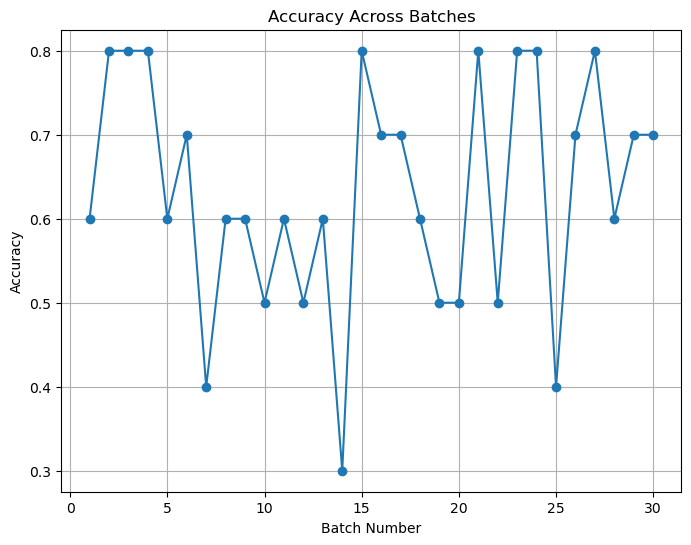

In [334]:
# Create a list of epochs (assuming one accuracy value per epoch)
epochs = range(1, len(pred_batch) + 1)

# Create the accuracy vs. epoch plot
plt.figure(figsize=(8, 6))  # Set the figure size (optional)
plt.plot(epochs, pred_batch, marker='o', linestyle='-')
plt.title('Accuracy Across Batches')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.grid(True)

# Show the plot (if you're running this in a Jupyter Notebook, you can omit plt.show())
plt.show()

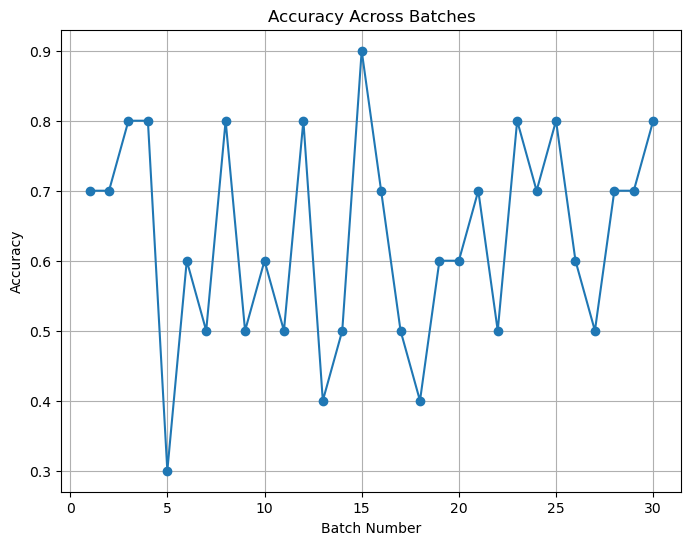

In [335]:
# Create a list of epochs (assuming one accuracy value per epoch)
epochs = range(1, len(enc_pred_batch) + 1)

# Create the accuracy vs. epoch plot
plt.figure(figsize=(8, 6))  # Set the figure size (optional)
plt.plot(epochs, enc_pred_batch, marker='o', linestyle='-')
plt.title('Accuracy Across Batches')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.grid(True)

# Show the plot (if you're running this in a Jupyter Notebook, you can omit plt.show())
plt.show()